In [1]:
from tqdm import tqdm
import os
import torch
import pretty_midi

In [2]:
midi_path = "/home/jongmin/userdata/MAESTRO/maestro-v3.0.0/2009/MIDI-Unprocessed_02_R1_2009_03-06_ORIG_MID--AUDIO_02_R1_2009_02_R1_2009_05_WAV.midi"

In [3]:
walked = os.walk(os.path.abspath(midi_path.replace(".midi", "*")))

In [4]:
len(list(walked))

0

In [5]:
def create_piano_roll(midi_notes, fs=100, note_range=(21, 109)):
    """
    Create a piano roll from the given MIDI notes.
    
    Parameters:
    midi_notes (np.array): An array of MIDI notes with the format [onset, offset, note, velocity].
    fs (int): The sampling frequency of the piano roll.
    note_range (tuple): The range of notes to include in the piano roll.
    rf (int): The receptive field of EnCodec token.
    sr (int): The sampling rate of the EnCodec model.
    
    Returns:
    np.array: A piano roll of the MIDI notes.
    """
    # Create an empty piano roll
    piano_roll = np.zeros((2, note_range[1] - note_range[0], fs*30))

    # Iterate over all notes
    for note in midi_notes:
        # Get the start and end indices for the note
        start = int(np.round((note[0]) * fs))
        end = int(np.round((note[1]) * fs))
    
        # Add the note to the piano roll
        if start == piano_roll.shape[-1]:
            continue

        piano_roll[1, int(note[2]) - note_range[0], start:end] = 1
        piano_roll[0, int(note[2]) - note_range[0], start] = 1

    return piano_roll

In [6]:
pm_loaded = pretty_midi.PrettyMIDI(midi_path)

In [7]:
def slice_midi(midi_data, start_time, end_time):

    # Create a new PrettyMIDI object for the sliced data
    sliced_midi_data = pretty_midi.PrettyMIDI()

    # Iterate over all instruments in the original MIDI data
    for instrument in midi_data.instruments:
        # Create a new instrument object for the sliced data
        sliced_instrument = pretty_midi.Instrument(program=instrument.program, is_drum=instrument.is_drum, name=instrument.name)

        # Slice the notes
        for note in instrument.notes:
            # If the note is within the slice times
            if start_time <= note.start < end_time:
                # Copy the note and adjust the start and end times
                new_note = pretty_midi.Note(
                    velocity=note.velocity,
                    pitch=note.pitch,
                    start=max(note.start, start_time) - start_time,
                    end=min(note.end, end_time) - start_time
                )
                sliced_instrument.notes.append(new_note)

        # Slice the pitch bends
        for pitch_bend in instrument.pitch_bends:
            if start_time <= pitch_bend.time < end_time:
                # Copy the pitch bend and adjust the time
                new_pitch_bend = pretty_midi.PitchBend(
                    pitch=pitch_bend.pitch,
                    time=pitch_bend.time - start_time
                )
                sliced_instrument.pitch_bends.append(new_pitch_bend)

        # Slice the control changes
        for control_change in instrument.control_changes:
            if start_time <= control_change.time < end_time:
                # Copy the control change and adjust the time
                new_control_change = pretty_midi.ControlChange(
                    number=control_change.number,
                    value=control_change.value,
                    time=control_change.time - start_time
                )
                sliced_instrument.control_changes.append(new_control_change)

        # Add the sliced instrument to the new MIDI data
        sliced_midi_data.instruments.append(sliced_instrument)

    return sliced_midi_data

In [8]:
pm_loaded.instruments[0].notes[-1].end, pm_loaded.instruments[0].notes[-1].end//30

(167.08854166666666, 5.0)

In [9]:
for i in range(int(pm_loaded.instruments[0].notes[-1].end//30)):
    sliced_midi = slice_midi(pm_loaded, i*30, (i+1)*30)
    transcribed_midi = pretty_midi.PrettyMIDI(midi_path.replace(".midi", "_bytedance_{}.mid".format(i*30)))

In [10]:
import numpy as np

In [11]:
pm_sliced = slice_midi(pm_loaded,60,90)

In [12]:
transcribed_midi = pretty_midi.PrettyMIDI(midi_path.replace(".midi", "_bytedance_{}.mid".format(60)))

In [ ]:
pm_synthed = pm_sliced.synthesize()
pm_synthed.shape

In [16]:
pm_sliced.instruments[0].notes

[Note(start=0.136719, end=0.309896, pitch=42, velocity=56),
 Note(start=0.158854, end=0.326823, pitch=71, velocity=53),
 Note(start=0.302083, end=0.343750, pitch=49, velocity=54),
 Note(start=0.363281, end=0.401042, pitch=52, velocity=60),
 Note(start=0.119792, end=0.451823, pitch=80, velocity=74),
 Note(start=0.167969, end=0.563802, pitch=68, velocity=52),
 Note(start=0.535156, end=0.609375, pitch=70, velocity=78),
 Note(start=0.477865, end=0.622396, pitch=54, velocity=59),
 Note(start=0.558594, end=0.622396, pitch=61, velocity=70),
 Note(start=0.661458, end=0.783854, pitch=64, velocity=71),
 Note(start=0.733073, end=0.816406, pitch=72, velocity=85),
 Note(start=0.752604, end=0.852865, pitch=60, velocity=64),
 Note(start=0.765625, end=0.919271, pitch=68, velocity=63),
 Note(start=0.902344, end=0.932292, pitch=54, velocity=62),
 Note(start=0.946615, end=1.000000, pitch=61, velocity=73),
 Note(start=0.923177, end=1.026042, pitch=73, velocity=95),
 Note(start=1.020833, end=1.083333, pitc

In [13]:
midi_path.replace(".midi", "_bytedance_{}.mid".format(60))

'/home/jongmin/userdata/MAESTRO/maestro-v3.0.0/2009/MIDI-Unprocessed_02_R1_2009_03-06_ORIG_MID--AUDIO_02_R1_2009_02_R1_2009_05_WAV_bytedance_60.mid'

In [15]:
transcribed_midi.write('2009_MIDI-Unprocessed_02_R1_2009_03-06_ORIG_MID--AUDIO_02_R1_2009_02_R1_2009_05_WAV_bytedance_60.mid')

In [14]:
pm_sliced.write("2009_MIDI-Unprocessed_02_R1_2009_03-06_ORIG_MID--AUDIO_02_R1_2009_02_R1_2009_05_WAV_sliced_60.mid")

In [ ]:
transcribed_synthed = transcribed_midi.synthesize()
transcribed_synthed.shape

(1366640,)

In [ ]:
transcribed_midi.write()

In [58]:
import IPython.display as ipd

In [12]:
# pm_sliced_pr = pm_sliced.instruments[0].get_piano_roll(fs=100)
# pm_sliced_pr.shape

In [68]:
a = []
for note in pm_sliced.instruments[0].notes:
    a.append([note.start, note.end, note.pitch, note.velocity])
a = np.array(a)
a

array([[ 0.13671875,  0.30989583, 42.        , 56.        ],
       [ 0.15885417,  0.32682292, 71.        , 53.        ],
       [ 0.30208333,  0.34375   , 49.        , 54.        ],
       ...,
       [29.8359375 , 29.91666667, 54.        , 83.        ],
       [29.86979167, 29.94270833, 64.        , 56.        ],
       [29.91666667, 29.95442708, 61.        , 57.        ]])

In [75]:
a_pr = create_piano_roll(a, fs=100)
a_pr.shape

(2, 88, 3000)

In [42]:
import mir_eval

In [43]:
a_pitches = []
a_intervals = []
for note in pm_sliced.instruments[0].notes:
    a_pitches.append(mir_eval.util.midi_to_hz(note.pitch))
    a_intervals.append([note.start, note.end])
a_pitches = np.array(a_pitches)
a_intervals = np.array(a_intervals)
a_pitches.shape, a_intervals.shape

((443,), (443, 2))

In [44]:
b_pitches = []
b_intervals = []
for note in transcribed_midi.instruments[0].notes:
    b_pitches.append(mir_eval.util.midi_to_hz(note.pitch))
    b_intervals.append([note.start, note.end])
b_pitches = np.array(b_pitches)
b_intervals = np.array(b_intervals)
b_pitches.shape, b_intervals.shape

((720,), (720, 2))

In [52]:
import mir_eval

In [51]:
met = mir_eval.transcription.precision_recall_f1_overlap(a_intervals, a_pitches, b_intervals, b_pitches, offset_ratio=None)
met

(0.2986111111111111,
 0.4853273137697517,
 0.36973344797936375,
 0.28663706714967097)

In [47]:
met = mir_eval.transcription.precision_recall_f1_overlap(a_intervals, a_pitches, b_intervals, b_pitches)
met

(0.04027777777777778,
 0.0654627539503386,
 0.04987102321582115,
 0.6365347937238959)

In [78]:
met = note_eval.evaluate(torch.Tensor(b_pr), torch.Tensor(a_pr))

In [79]:
met

defaultdict(list,
            {'metric/note/precision': [0.28304597701149425],
             'metric/note/recall': [0.4020408163265306],
             'metric/note/f1': [0.3322091062394603],
             'metric/note/overlap': [0.3352592796718505],
             'metric/note-with-offsets/precision': [0.017241379310344827],
             'metric/note-with-offsets/recall': [0.024489795918367346],
             'metric/note-with-offsets/f1': [0.02023608768971332],
             'metric/note-with-offsets/overlap': [0.7574217648571047],
             'metric/frame/f1': [0.21121251629726212],
             'metric/frame/precision': [0.1386986301369863],
             'metric/frame/recall': [0.4426229508196721],
             'metric/frame/accuracy': [0.11807580174927114],
             'metric/frame/substitution_error': [0.47540983606557374],
             'metric/frame/miss_error': [0.08196721311475409],
             'metric/frame/false_alarm_error': [2.273224043715847],
             'metric/frame/tota

In [72]:
b = []
for note in transcribed_midi.instruments[0].notes:
    b.append([note.start, note.end, note.pitch, note.velocity])
b = np.array(b)
b

array([[ 0.14453125,  0.21875   , 71.        , 53.        ],
       [ 0.14583333,  0.38932292, 49.        , 61.        ],
       [ 0.47135417,  0.52994792, 70.        , 54.        ],
       ...,
       [29.2578125 , 29.98958333, 61.        , 65.        ],
       [29.84635417, 29.98958333, 64.        , 59.        ],
       [29.80729167, 29.98958333, 66.        , 58.        ]])

In [76]:
b_pr = create_piano_roll(b, fs=100)
b_pr.shape

(2, 88, 3000)

In [45]:
transcribed_midi = pretty_midi.PrettyMIDI(midi_path.replace(".midi", "_bytedance_60.mid"))

In [46]:
t_pr = transcribed_midi.instruments[0].get_piano_roll(fs=100)

In [47]:
t_pr_booled = t_pr > 0

In [48]:
t_onset = transcribed_midi.instruments[0].get_onsets()
# t_onset

In [49]:
t_pr.shape

(128, 2998)

In [50]:
t_pr[21:109].shape

(88, 2998)

In [51]:
t_pr_booled[21:109].shape

(88, 2998)

In [52]:
import matplotlib.pyplot as plt

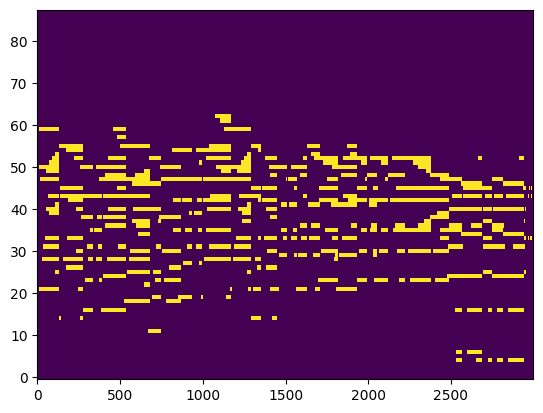

In [53]:
plt.imshow((pm_sliced_pr > 0)[21:109], aspect='auto', origin='lower', interpolation='none')

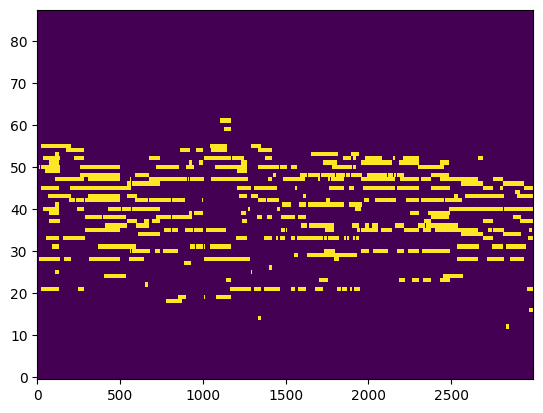

In [54]:
plt.imshow(t_pr_booled[21:109], aspect='auto', origin='lower', interpolation='none')

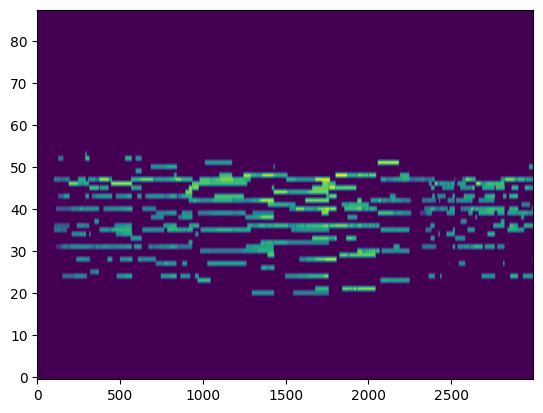

In [22]:
plt.imshow(t_pr[21:109], aspect='auto', origin='lower')

In [14]:
# b_pitches = []
# b_intervals = []
# for note in transcribed_midi.instruments[0].notes:
#     b_pitches.append(note.pitch)
#     b_intervals.append([note.start, note.end])
# b_pitches = np.array(b_pitches)
# b_intervals = np.array(b_intervals)
# b_pitches, b_intervals

(array([56, 68, 56, 52, 68, 64, 68, 73, 64, 68, 52, 56, 45, 57, 52, 52, 45,
        57, 68, 64, 61, 67, 52, 67, 55, 45, 67, 55, 52, 52, 67, 55, 52, 61,
        68, 52, 55, 45, 61, 67, 52, 55, 61, 57, 68, 55, 52, 49, 74, 45, 61,
        52, 56, 64, 67, 57, 68, 73, 49, 55, 52, 52, 64, 46, 52, 64, 68, 52,
        64, 68, 58, 46, 61, 66, 52, 68, 56, 52, 68, 64, 52, 56, 52, 61, 64,
        61, 68, 52, 56, 66, 56, 68, 64, 49, 56, 52, 67, 61, 52, 67, 57, 52,
        67, 61, 57, 67, 55, 52, 64, 64, 67, 45, 57, 61, 64, 52, 67, 57, 55,
        49, 64, 73, 73, 64, 57, 52, 45, 55, 67, 49, 61, 66, 52, 68, 54, 64,
        49, 68, 73, 66, 54, 64, 70, 52, 49, 68, 56, 56, 68, 64, 68, 56, 49,
        68, 71, 68, 52, 68, 49, 61, 56, 52, 68, 52, 60, 68, 48, 68, 52, 60,
        64, 68, 59, 52, 56, 64, 68, 71, 52, 48, 60, 64, 52, 68, 60, 45, 52,
        60, 64, 68, 64, 52, 60, 57, 60, 68, 56, 52, 64, 48, 60, 57, 45, 69,
        71, 64, 56, 52, 68, 64, 68, 59, 56, 63, 60, 56, 45, 48, 60, 69, 45,
        57, 

In [13]:
import note_eval

In [15]:
c = note_eval.notes_to_frames(b_pitches, b_intervals, [3000, 88])

TypeError: slice indices must be integers or None or have an __index__ method

In [ ]:
for i in range(int(pm_loaded.instruments[0].notes[-1].end//30)):
    sliced_midi = slice_midi(pm_loaded, i*30, (i+1)*30)
    transcribed_midi = pretty_midi.PrettyMIDI(midi_path.replace(".midi", "_bytedance_{}.mid".format(i*30)))

    a = []
    for note in sliced_midi.instruments[0].notes:
        a.append([note.start, note.end, note.pitch, note.velocity])
    a = np.array(a)
    np.save(midi_path.replace(".midi", "_bytedance_{}.npy".format(i*30)), a)

    transcribed_midi.instruments[0].notes = sliced_midi.instruments[0].notes
    transcribed_midi.write(midi_path.replace(".midi", "_bytedance_{}.mid".format(i*30)))

    print(i, "done")

In [ ]:
for dirpath, dirnames, filenames in os.walk("/home/jongmin/userdata/MAESTRO/maestro-v3.0.0/"):
    for filename in tqdm([f for f in filenames if f.endswith(".midi")]):
        

In [80]:
splits = torch.load("/home/jongmin/userdata/MAESTRO/maestro-v3.0.0/maestro-v3.0.0_split.pt")
val_split = splits["validation"]

In [81]:
root = "/home/jongmin/userdata/MAESTRO/maestro-v3.0.0/"

In [93]:
label_path = os.path.join(root, val_split[0])
print(label_path)
label = pretty_midi.PrettyMIDI(label_path)
length_sec = label.instruments[0].notes[-1].end
metrics = []
for i in range(int(length_sec//30)):
    label_midi = slice_midi(label, i*30, (i+1)*30)
    transcribed_midi = pretty_midi.PrettyMIDI(label_path.replace(".midi", "_bytedance_{}.mid".format(i*30)))

    label_array = []
    for note in label_midi.instruments[0].notes:
        label_array.append([note.start, note.end, note.pitch, note.velocity])
    label_array = np.array(label_array)
    label_pr = create_piano_roll(label_array, fs=100)

    transcribed_array = []
    for note in transcribed_midi.instruments[0].notes:
        transcribed_array.append([note.start, note.end, note.pitch, note.velocity])
    transcribed_array = np.array(transcribed_array)
    transcribed_pr = create_piano_roll(transcribed_array, fs=100)

    metric = note_eval.evaluate(torch.Tensor(label_pr), torch.Tensor(transcribed_pr))
    print(metric)
    metrics.append(metric)
label_midi = slice_midi(label, length_sec-30, length_sec)
transcribed_midi = pretty_midi.PrettyMIDI(label_path.replace(".midi", "_bytedance_{}.mid".format(-1)))

label_array = []
for note in label_midi.instruments[0].notes:
    label_array.append([note.start, note.end, note.pitch, note.velocity])
label_array = np.array(label_array)
label_pr = create_piano_roll(label_array, fs=100)

transcribed_array = []
for note in transcribed_midi.instruments[0].notes:
    transcribed_array.append([note.start, note.end, note.pitch, note.velocity])
transcribed_array = np.array(transcribed_array)
transcribed_pr = create_piano_roll(transcribed_array, fs=100)

metric = note_eval.evaluate(torch.Tensor(label_pr), torch.Tensor(transcribed_pr))
print(metric)
metrics.append(metric)


/home/jongmin/userdata/MAESTRO/maestro-v3.0.0/2006/MIDI-Unprocessed_17_R1_2006_01-06_ORIG_MID--AUDIO_17_R1_2006_04_Track04_wav.midi


/home/jongmin/.local/share/virtualenvs/audiocraft-ssbSDm-j/lib/python3.8/site-packages/mir_eval/multipitch.py:276: UserWarning: Estimate frequencies are all empty.
  warnings.warn("Estimate frequencies are all empty.")
/home/jongmin/.local/share/virtualenvs/audiocraft-ssbSDm-j/lib/python3.8/site-packages/mir_eval/multipitch.py:283: UserWarning: Reference frequencies are all empty.
  warnings.warn("Reference frequencies are all empty.")
/home/jongmin/.local/share/virtualenvs/audiocraft-ssbSDm-j/lib/python3.8/site-packages/mir_eval/multipitch.py:323: UserWarning: Reference frequencies are all empty.
  warnings.warn("Reference frequencies are all empty.")


defaultdict(<class 'list'>, {'metric/note/precision': [0.6038647342995169], 'metric/note/recall': [0.3250975292587776], 'metric/note/f1': [0.42265426880811496], 'metric/note/overlap': [0.31124526118335316], 'metric/note-with-offsets/precision': [0.07004830917874397], 'metric/note-with-offsets/recall': [0.0377113133940182], 'metric/note-with-offsets/f1': [0.04902789518174133], 'metric/note-with-offsets/overlap': [0.6880102940466336], 'metric/frame/f1': [0.0], 'metric/frame/precision': [0.0], 'metric/frame/recall': [0.0], 'metric/frame/accuracy': [0.0], 'metric/frame/substitution_error': [0.0], 'metric/frame/miss_error': [0.0], 'metric/frame/false_alarm_error': [0.0], 'metric/frame/total_error': [0.0], 'metric/frame/chroma_precision': [0.0], 'metric/frame/chroma_recall': [0.0], 'metric/frame/chroma_accuracy': [0.0], 'metric/frame/chroma_substitution_error': [0.0], 'metric/frame/chroma_miss_error': [0.0], 'metric/frame/chroma_false_alarm_error': [0.0], 'metric/frame/chroma_total_error': [

In [103]:
dict(metrics[5])["metric/frame/accuracy"][0]

TypeError: 'numpy.dtype[float64]' object is not callable

In [ ]:
metrics = []
for filename in val_split:
    label_path = os.path.join(root, filename)
    print(label_path)
    label = pretty_midi.PrettyMIDI(label_path)
    length_sec = label.instruments[0].notes[-1].end
    for i in range(int(length_sec//30)):
        label_midi = slice_midi(label, i*30, (i+1)*30)
        transcribed_midi = pretty_midi.PrettyMIDI(label_path.replace(".midi", "_bytedance_{}.mid".format(i*30)))

        label_array = []
        for note in label_midi.instruments[0].notes:
            label_array.append([note.start, note.end, note.pitch, note.velocity])
        label_array = np.array(label_array)
        label_pr = create_piano_roll(label_array, fs=100)

        transcribed_array = []
        for note in transcribed_midi.instruments[0].notes:
            transcribed_array.append([note.start, note.end, note.pitch, note.velocity])
        transcribed_array = np.array(transcribed_array)
        transcribed_pr = create_piano_roll(transcribed_array, fs=100)

        metric = note_eval.evaluate(torch.Tensor(label_pr), torch.Tensor(transcribed_pr))
        metric["filename"] = filename
        metric["idx"] = i
        print(metric)
        metrics.append(metric)
    label_midi = slice_midi(label, length_sec-30, length_sec)
    transcribed_midi = pretty_midi.PrettyMIDI(label_path.replace(".midi", "_bytedance_{}.mid".format(-1)))

    label_array = []
    for note in label_midi.instruments[0].notes:
        label_array.append([note.start, note.end, note.pitch, note.velocity])
    label_array = np.array(label_array)
    label_pr = create_piano_roll(label_array, fs=100)

    transcribed_array = []
    for note in transcribed_midi.instruments[0].notes:
        transcribed_array.append([note.start, note.end, note.pitch, note.velocity])
    transcribed_array = np.array(transcribed_array)
    transcribed_pr = create_piano_roll(transcribed_array, fs=100)

    metric = note_eval.evaluate(torch.Tensor(label_pr), torch.Tensor(transcribed_pr))
    metric["filename"] = filename
    metric["idx"] = -1
    print(metric)
    metrics.append(metric)
